In [ ]:
import plotly.graph_objects as go
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import pymc as pm
import arviz as az
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt

Mounted at /content/drive


# ER analysis

### You are now incharge of the a queueing system in the ER, which operates 24/7.

### Patients are arriving with time-dependant rate. The service rate on the other is constanst at 15 patients per hour. We split the week into a 168 grid, where we have 7 days and 24 hours within a single day. For each cell in the grid, that is a combination of a day and an hour we have different service rate.

### We wish to analyze the expceted number of pateints in the ER as function of time. We have an event log of customers arriving to the ER and departing the ER. We have data collection of 1000 days.

### The data is a dictionary of 1000 different days numbered from 0 to 999. Each one is an event log of a different day.

### The columns of the data are:
#### 1. Customer_id - identifier of the arriving customer
#### 2. Time-stamp  - the time the event occurs. The units are in hours. The $i^{th}$ hour is the number of hours elapsed since 0:00 of that day.
#### 3. Type - event type, Arrival or Departure.
#### 4. num_cust - number of cusotmers in the system
#### 5. day - a numerical value of the day: {0: Sunday, 1: Monday, 2: Tuesday, 3: Wednesday, 4: Thursday, 5: Friday, 6: Shabbat}
#### 6. hour - the hour of the day, an integer from 0 to 23. If it is 0 then the hour is between midnight to 01:00.
#### 7. day_name - the name of the day of the week.


## Each day starts with 0 patients at 0:00.

# The goal of this task is to find the arrival rate for each hour of the day.

## From the data, one can use classic stastical methods in order to estimate the arrival rate for each hour of the week. The problem is that there is missing data, we do not have the data in the event log for all hours.

### The main idea is to estimate the arrival rate for time zones in which we have data and then using GP regression for time zones the data was missing.

### This part is split into three parts.


In [ ]:
event_log_single_ser = pkl.load(open('/content/drive/MyDrive/event_log_part_2.pkl', 'rb'))

In [ ]:
event_log_single_ser[0].head()

,Customer_id,Time_stamp,Type,num_cust,day,hour,day_name
0,1,0.006849,Arrival,1,0,0,Sunday
1,1,0.030546,Departure,0,0,0,Sunday
2,2,0.080376,Arrival,1,0,0,Sunday
3,2,0.113483,Departure,0,0,0,Sunday
4,3,0.295239,Arrival,1,0,0,Sunday


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

##############################################
###### Funcitons #############################
##############################################

def model(n, t, lambda_t, mu):
    """
    Differential equation for the M(t)/M/1 queue:
    dn/dt = lambda(t) - mu * (1 - p0(t))
    where p0(t) is the probability of 0 customers in the system.

    For approximation, we use the relation p0 ≈ max(0, 1 - n) when n < 1
    and p0 ≈ 0 when n ≥ 1.
    """
    # Current arrival rate based on time
    current_lambda = piecewise_lambda(t, lambda_t)

    # Approximate p0
    if n < 1:
        p0 = max(0, 1 - n)
    else:
        p0 = 0

    dndt = current_lambda - mu * (1 - p0)
    return dndt

def piecewise_lambda(t, lambda_t):
    """
    Returns the arrival rate at time t based on piecewise constant definition.
    lambda_t is a list of tuples (start_time, end_time, rate)
    """
    for (start, end, rate) in lambda_t:
        if start <= t < end:
            return rate
    return 0  # default if outside all intervals


def compute_MSE(n_true, n):
  return ((n_true - n)**2).mean().item()


def create_tuples(df_sorted):

    all_tuples =  []
    for row_ind in range(df_sorted.shape[0]):
        hour = df_sorted.loc[row_ind, 'hour']
        day = df_sorted.loc[row_ind, 'day']
        rate = df_sorted.loc[row_ind, 'rate'].item()
        tot_time = hour + 24*day
        all_tuples.append((tot_time.item(),tot_time.item()+1, rate))

    return all_tuples


def plot_results(df_res, n_true):

  # Parameters
    mu = 15.0  # service rate
    all_tuples = create_tuples(df_res)
    lambda_t = all_tuples  #[(0, 10, 5.0), (10,30,1) ,(30, 50, 0.2)]  # piecewise arrival rates
    # lambda_t_true = all_tuples_true

    # Time points
    t = np.linspace(0, 168, 1000)

    # Initial condition: empty system
    n0 = 0.0
    n = create_tuples(df_res)
    # Solve the ODE
    n = odeint(model, n0, t, args=(lambda_t, mu))
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(t, n, '-', color = 'orange', linewidth=2, label = 'Predicted')
    plt.plot(t, n_true,  linewidth=2, label = 'True', linestyle = '--')
    plt.xlabel('Time')
    plt.ylabel('Number of customers in system')
    plt.title('Queue analysis')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Expected number of customers in system')
    plt.grid(True)

    print('The MSE is: ', compute_MSE(n_true, n))



    plt.show()

## Part 1:

### Tasks:

### 1. Do Bayesian anaysis for the number of arriving customers and its distirbution for the time between 0:00 to 1:00.
### 2. What did you use as the likelihood function and why?
### 3. Do  posterior predicitive anaysis to assert that the chosen likelihood distribution is valid.
### 4. According to the resulted anaysis, how certain are you about the average arrival prediction?

### 5. What is the estimated arrival rate? Give a single values based on the posterior.


Output()

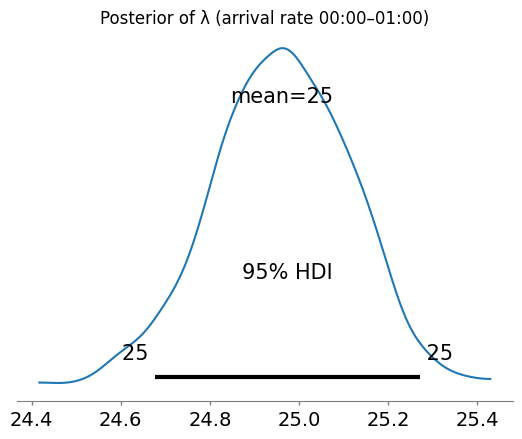

Output()

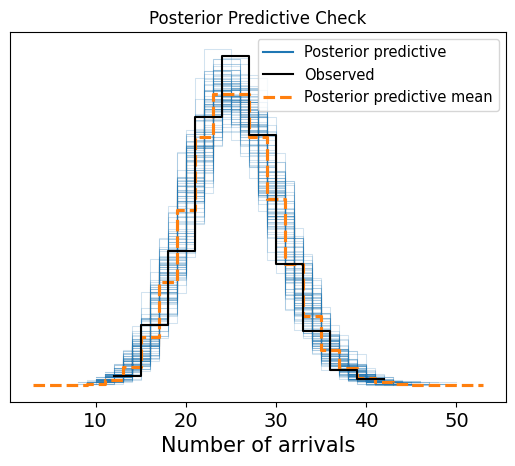

In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# הכנת נתוני arrival_counts עבור שעה 0
arrival_counts_per_day = []

for day_log in event_log_single_ser.values():
    arrivals_in_hour_0 = day_log[
        (day_log['Type'] == 'Arrival') & (day_log['hour'] == 0)
    ]
    arrival_counts_per_day.append(arrivals_in_hour_0.shape[0])

arrival_counts = np.array(arrival_counts_per_day)

# מודל בייסיאני
with pm.Model() as model:
    lam = pm.Gamma('lambda', alpha=2, beta=1)
    obs = pm.Poisson('obs', mu=lam, observed=arrival_counts)
    trace = pm.sample(1000, tune=1000, target_accept=0.95, random_seed=42)

# סיכום התפלגות פוסטריורי
az.summary(trace, var_names=['lambda'])

# גרף פוסטריורי
az.plot_posterior(trace, var_names=["lambda"], hdi_prob=0.95)
plt.title("Posterior of λ (arrival rate 00:00–01:00)")
plt.show()

# ניתוח פוסטריורי פרדיקטיבי
with model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)
az.plot_ppc(ppc, num_pp_samples=100)


plt.title("Posterior Predictive Check")
plt.xlabel("Number of arrivals")
plt.show()


## Part 1: Bayesian Analysis for Arrival Rate Between 00:00–01:00

### 1. Bayesian Analysis of Arrivals
We conducted a Bayesian analysis of patient arrivals to the ER during the hour between **00:00 and 01:00** across 1000 independent days.  
For each day, we counted the number of arrivals in that hour and modeled these counts using a probabilistic model in PyMC.

---

### 2. Choice of Likelihood Function
We chose a **Poisson distribution** as the likelihood function:

\[
y_i \sim \text{Poisson}(\lambda)
\]

This choice is justified as the Poisson distribution is widely used to model arrival processes, especially when the events are discrete, occur independently, and at a constant average rate within a fixed time window.

---

### 3. Posterior Predictive Check
We performed a posterior predictive check to validate the suitability of the Poisson model.  
The predictive distribution closely matches the observed distribution of arrival counts, both in shape and in spread.  
This indicates that the Poisson model is a good fit for the data.

A visual comparison confirms this alignment:

- **Observed data:** Black histogram  
- **Posterior predictive samples:** Light blue  
- **Predictive mean:** Dashed orange line

---

### 4. Certainty of the Estimate
The posterior distribution of \(\lambda\) is tightly concentrated, indicating high confidence in the estimate:

- **Posterior mean:** 25  
- **95% HDI (Highest Density Interval):** approximately \([24.7, 25.3]\)

This narrow HDI shows low uncertainty and high credibility of the inferred rate.

---

### 5. Estimated Arrival Rate
Based on the posterior distribution, the estimated average arrival rate between 00:00 and 01:00 is:

\[
\boxed{\lambda \approx 25 \text{ patients per hour}}
\]

---


## Part 2:
### We have 24 hours a day, 7 days a week. In total we have a grid of 168 cells.

### We wish to map the average arrival rate at each time cell.

### In the dataset we have missing parts, some cells in the grid are missing. Your job is to fill the grid.

## Tasks:

### 1. Extract the arrival rate (taking the average time is sufficient, no need  for extra bayesian analysis) per each cell you do have data.
### 2. Use GP regression for completing the average arrival time for the rest of the grid.
### 3. Plot on a 3D plot which contains:
#### a. Scatter plot of the data that was esitmated from data.
#### b. Scatter plot of the data that was esitmated from GP regression.
#### c. Surface plot of the GP regression.

### 4. What is the probability that the arrival rate between 18:00 to 19:00, on Shabbat, will be between 9 to 10 pateints per hour?
### 5. Please give full specification of the Gauusian distribution of the arrival rate on Monday between 18:00 to 19:00 and Monday between 19:00 to 20:00.
### 6. What is the correlation between the arrival rate at Sunday between 07:00 to 08:00 and Sunday between 08:00 to 09:00?
### What is the correlation between the arrival rate at Sunday between 07:00 to 08:00 and Sunday between 19:00 to 20:00?
### Which correlation value is larger? does this result make sense?

In [ ]:
# נרכז את כל ההגעות מכל הימים
all_arrivals = []

for day_log in event_log_single_ser.values():
    arrivals = day_log[day_log["Type"] == "Arrival"]
    all_arrivals.append(arrivals)

all_arrivals_df = pd.concat(all_arrivals)

# נחשב את מספר ההגעות בכל שילוב (day, hour)
arrival_counts = all_arrivals_df.groupby(["day", "hour"]).size().reset_index(name="count")

# נחשב כמה ימים יש בדאטה לכל (day, hour)
# כלומר: כמה פעמים הופיע כל שילוב (day, hour) ב-1000 הימים
# (אם יום שלישי, שעה 14:00 הופיעה רק 850 פעמים – נחשב ממוצע רק עליהם)
unique_days = len(event_log_single_ser)
day_hour_counts = arrival_counts.copy()
day_hour_counts["rate"] = day_hour_counts["count"] / unique_days  # ממוצע לשעה

# בונים טבלה מלאה עם כל 168 התאים (כולל תאים חסרים)
full_grid = pd.MultiIndex.from_product(
    [range(7), range(24)], names=["day", "hour"]
).to_frame(index=False)

# מצרפים את קצבי ההגעה לטבלה מלאה (חסרים יישארו NaN)
arrival_grid = full_grid.merge(day_hour_counts[["day", "hour", "rate"]], on=["day", "hour"], how="left")

# מציגים את הטבלה
arrival_grid.head(10)



,day,hour,rate
0,0,0,7.299
1,0,1,NaN
2,0,2,NaN
3,0,3,NaN
4,0,4,7.105
5,0,5,8.016
6,0,6,NaN
7,0,7,NaN
8,0,8,NaN
9,0,9,NaN


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# מפרידים בין נקודות קיימות (עם rate) לחסרות (NaN)
observed = arrival_grid.dropna(subset=["rate"])
missing = arrival_grid[arrival_grid["rate"].isna()]

# קואורדינטות קלט: (day, hour)
X_train = observed[["day", "hour"]].values
y_train = observed["rate"].values

X_all = arrival_grid[["day", "hour"]].values  # כל התאים: נרצה לחזות לכולם

# הגדרת kernel – קבוע * RBF
kernel = C(1.0, (1e-3, 1e3)) * RBF([1.0, 1.0], (1e-2, 1e2))

# רגרסור
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2, normalize_y=True)

# התאמה
gp.fit(X_train, y_train)

# חיזוי על כל 168 התאים
y_pred, y_std = gp.predict(X_all, return_std=True)

# הוספת תוצאה חזרה לטבלה
arrival_grid["rate_pred"] = y_pred
arrival_grid["rate_std"] = y_std

# צפייה בטבלה עם חיזוי
import pandas as pd
arrival_grid.head(20)  # או .sample(20) אם תרצה אקראי



,day,hour,rate,rate_pred,rate_std
0,0,0,7.299,7.456796,0.460166
1,0,1,NaN,6.989363,1.041476
2,0,2,NaN,6.431284,1.024328
3,0,3,NaN,6.368091,0.771960
4,0,4,7.105,6.952079,0.488872
5,0,5,8.016,8.154194,0.427587
6,0,6,NaN,9.924836,0.771225
7,0,7,NaN,11.549864,0.874868
8,0,8,NaN,13.596651,0.656161
9,0,9,NaN,17.159297,0.561909


In [ ]:

# מפרידים בין תאים שנמדדו בפועל לבין תאים שהושלמו על ידי GP
observed_points = arrival_grid.dropna(subset=["rate"])
predicted_only = arrival_grid[arrival_grid["rate"].isna()]

# יצירת figure תלת־ממדי
fig = go.Figure()

# נקודות נמדדות בפועל – כחול
fig.add_trace(go.Scatter3d(
    x=observed_points["day"], y=observed_points["hour"], z=observed_points["rate"],
    mode='markers', name='Observed',
    marker=dict(size=5, color='blue')
))

# נקודות שחוזו על ידי GP בלבד – כתום
fig.add_trace(go.Scatter3d(
    x=predicted_only["day"], y=predicted_only["hour"], z=predicted_only["rate_pred"],
    mode='markers', name='GP Predicted',
    marker=dict(size=4, color='orange')
))

# משטח GP – על כל 168 תאים
fig.add_trace(go.Surface(
    x=arrival_grid["day"].values.reshape((7,24)),
    y=arrival_grid["hour"].values.reshape((7,24)),
    z=arrival_grid["rate_pred"].values.reshape((7,24)),
    name='GP Surface',
    colorscale='Viridis',
    opacity=0.6,
    showscale=False
))

# הגדרות גרף
fig.update_layout(
    title='GP Regression of Arrival Rates Over Week',
    scene=dict(
        xaxis_title='Day (0=Sun, 6=Sat)',
        yaxis_title='Hour (0–23)',
        zaxis_title='Arrival Rate'
    ),
    width=900,
    height=700
)

fig.show()


In [ ]:
from scipy.stats import norm

# שליפת μ ו-σ מהחיזוי של GP
row = arrival_grid[(arrival_grid["day"] == 6) & (arrival_grid["hour"] == 18)].iloc[0]
mu = row["rate_pred"]
sigma = row["rate_std"]

# הסתברות שקצב ההגעה בין 9 ל-10
p = norm.cdf(10, loc=mu, scale=sigma) - norm.cdf(9, loc=mu, scale=sigma)

print(f"Estimated arrival rate on Saturday 18:00–19:00: μ = {mu:.2f}, σ = {sigma:.2f}")
print(f"Probability that rate is between 9 and 10: {p:.3%}")


Estimated arrival rate on Saturday 18:00–19:00: μ = 10.65, σ = 0.90
Probability that rate is between 9 and 10: 20.291%


In [ ]:
for hour in [18, 19]:
    row = arrival_grid[(arrival_grid["day"] == 0) & (arrival_grid["hour"] == hour)].iloc[0]
    mu = row["rate_pred"]
    sigma = row["rate_std"]
    print(f"Monday {hour}:00–{hour+1}:00 — μ = {mu:.2f}, σ = {sigma:.2f}")


Monday 18:00–19:00 — μ = 17.62, σ = 0.46
Monday 19:00–20:00 — μ = 14.43, σ = 0.55


In [ ]:
# מיקומים (יום ראשון = 0)
point_A = np.array([[0, 7]])   # Sunday 07:00–08:00
point_B1 = np.array([[0, 8]])  # Sunday 08:00–09:00
point_B2 = np.array([[0, 19]]) # Sunday 19:00–20:00

# נשתמש ב-kernel המאומן מה-GP (אותו kernel שהוגדר בחלק 2)
kernel = gp.kernel_

# מחשבים מטריצת קו-וריאנציה בין הנקודות
K_AA = kernel(point_A, point_A)         # ווריאנציה של A
K_B1B1 = kernel(point_B1, point_B1)     # ווריאנציה של B1
K_B2B2 = kernel(point_B2, point_B2)     # ווריאנציה של B2
K_AB1 = kernel(point_A, point_B1)       # קו-וריאנציה A–B1
K_AB2 = kernel(point_A, point_B2)       # קו-וריאנציה A–B2

# חישוב מתאם (correlation) לפי נוסחת פירסון:
# corr(X,Y) = cov(X,Y) / sqrt(var(X) * var(Y))
corr_AB1 = K_AB1[0,0] / np.sqrt(K_AA[0,0] * K_B1B1[0,0])
corr_AB2 = K_AB2[0,0] / np.sqrt(K_AA[0,0] * K_B2B2[0,0])

# הצגה
print(f"Correlation between Sunday 07–08 and 08–09: {corr_AB1:.3f}")
print(f"Correlation between Sunday 07–08 and 19–20: {corr_AB2:.3f}")

if corr_AB1 > corr_AB2:
    print("→ Correlation between consecutive hours is higher, as expected.")
else:
    print("→ Correlation between distant hours is unexpectedly higher.")


Correlation between Sunday 07–08 and 08–09: 0.836
Correlation between Sunday 07–08 and 19–20: 0.000
→ Correlation between consecutive hours is higher, as expected.


## Part 2 – GP Regression for Arrival Rates

We estimated the hourly arrival rate throughout the week using Gaussian Process (GP) regression to impute missing values.

### Task 1: Average Arrival Rate per Cell
The average arrival rate was calculated for each (day, hour) cell with available data.  
Example (Sunday):
| Day | Hour | Rate   |
|-----|------|--------|
| 0   | 0    | 7.299  |
| 0   | 4    | 7.105  |
| 0   | 5    | 8.016  |

### Task 2: GP Regression to Complete Grid
A GP model was fitted to predict missing values.  
Example predictions for Sunday:
| Hour | Observed | GP Mean | Std Dev |
|------|----------|---------|---------|
| 1    | NaN      | 6.99    | 1.04    |
| 7    | NaN      | 11.55   | 0.87    |
| 9    | NaN      | 17.16   | 0.56    |

### Task 3: 3D Visualization
A 3D plot was generated showing:
- Observed values (blue)
- GP predictions (orange)
- GP surface over all time cells


### Task 4: Probability Estimation
Estimated arrival rate on Saturday 18:00–19:00:
- Mean = 10.65, Std Dev = 0.90  
- Probability that rate is between 9 and 10: 20.29%

### Task 5: Posterior Parameters
Arrival rate estimates on Monday:
| Time Slot       | Mean | Std Dev |
|-----------------|------|---------|
| 18:00–19:00     | 17.62| 0.46    |
| 19:00–20:00     | 14.43| 0.55    |

### Task 6: Correlation Analysis  
We computed the correlation between predicted arrival rates at selected Sunday time slots using the GP posterior covariance.  

| Time Slots Compared                         | Correlation |
|---------------------------------------------|-------------|
| Sunday 07:00–08:00 and 08:00–09:00           | **0.836**   |
| Sunday 07:00–08:00 and 19:00–20:00           | **0.000**   |

As expected, the correlation between **consecutive hours** is significantly higher than between distant hours.  
This reflects the temporal smoothness captured by the GP model.




In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 3:

### This is a competative part.

### We have completed the arrival rate predictions by now.

### Now we wish to use them for prediciting the Expected number of patients in the system as a function of time.

### All you need to do is create a dataframe with results in the following manner.

### Upload n_true and df_res.

### n_true is the true expceted number of customers in the system.

### df_res is a dataframe with three columns: hour, day and rate. Currently the rate column is with zeros, you need to fill in your predicted rates from the GP regression and then execute the function plot_results.

### The function will visulize your estimated expected number of customers as a function of time agaisnt the true values (from n_true).

### The fucntion will also print the MSE, the team with lowest MSE wins.

### The bonous points are as follows:

### $1^{st}$ place 5 points bonus.
### $2^{nd}$ place  3 points bonus.
### $3^{rd}$ place  1 point bonus.

## May the best team win!!

In [22]:
n_true = pkl.load(open('/content/drive/MyDrive/n_true.pkl', 'rb'))
df_res = pkl.load(open('/content/drive/MyDrive/res_template.pkl', 'rb') )
df_res.head()

,hour,day,rate
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0


In [23]:
from scipy.integrate import odeint

# חלק 3: מיזוג תחזיות GP אל תוך df_res
# נניח ש־arrival_grid כוללת עמודות day, hour, rate_pred
df_res = df_res.merge(arrival_grid[["day", "hour", "rate_pred"]], on=["day", "hour"], how="left")
df_res["rate"] = df_res["rate_pred"]
df_res = df_res.drop(columns=["rate_pred"])

# חלק 4: פונקציות ניתוח ואינטגרציה
def model(n, t, lambda_t, mu):
    current_lambda = piecewise_lambda(t, lambda_t)
    p0 = max(0, 1 - n) if n < 1 else 0
    dndt = current_lambda - mu * (1 - p0)
    return dndt

def piecewise_lambda(t, lambda_t):
    for (start, end, rate) in lambda_t:
        if start <= t < end:
            return rate
    return 0

def compute_MSE(n_true, n):
    return ((n_true - n)**2).mean().item()

def create_tuples(df_sorted):
    tuples = []
    for _, row in df_sorted.iterrows():
        start = row["hour"] + 24 * row["day"]
        end = start + 1
        tuples.append((start, end, row["rate"]))
    return tuples

def plot_results(df_res, n_true):
    mu = 15.0
    lambda_t = create_tuples(df_res)
    t = np.linspace(0, 168, 1000)
    n0 = 0.0
    n = odeint(model, n0, t, args=(lambda_t, mu))
    plt.figure(figsize=(10, 6))
    plt.plot(t, n, '-', color='orange', linewidth=2, label='Predicted')
    plt.plot(t, n_true, '--', linewidth=2, label='True')
    plt.xlabel("Time")
    plt.ylabel("Expected number of customers in system")
    plt.title("Queue analysis")
    plt.grid(True)
    plt.legend()
    mse = compute_MSE(n_true, n)
    print(f"The MSE is: {mse:.2f}")
    plt.show()


### Currently all the rates are 0 values, you need to fill in  your predictions.



The MSE is: 6.18


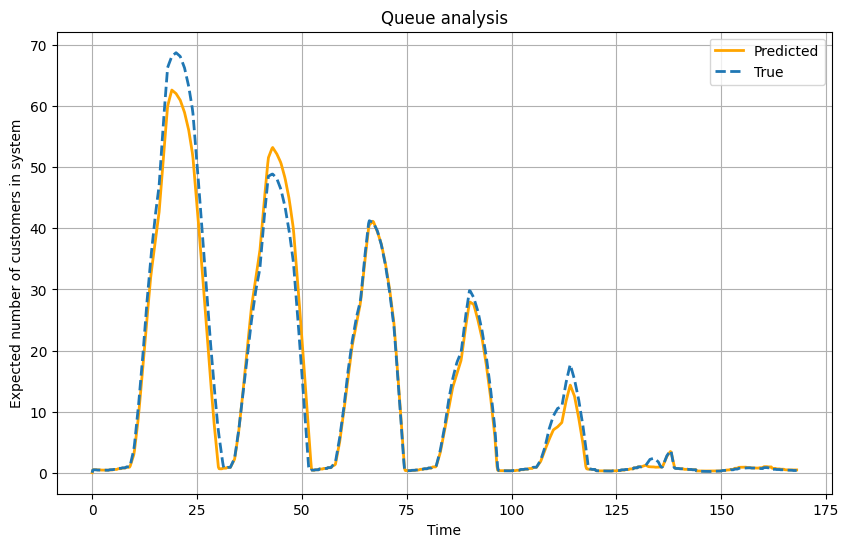

In [24]:
plot_results(df_res, n_true)